<a href="https://colab.research.google.com/github/andersonjhones/Previsao-com-o-modelo-SARIMA/blob/main/Aplica%C3%A7%C3%A3o_do_modelo_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Previsões para a série temporal de energia despachada no sistema elétrico interligado nacional por meio de termelétricas que funcionam a óleo combustível e a óleo diesel.**


As termelétricas desempenham um importante papel de fornecimento de energia ao sistema elétrico interligado nacional. Dentre as termelétricas pode-se destacar as usinas movidas à gás natural, petróleo e a carvão mineral. Dentre as usinas termelétricas que funcionam através de petróleo petróleo estão a óleo combustível e a óleo diesel, que representam a maior parte das usinas com funcionamento a petróleo. Neste notebook será feita uma análise da série temporal de energia despachada no sistema elétrico interligado nacional por parte das usinas que trabalham  a óleo combustível e a óleo diesel. Destaca-se que no Brasil a segunda fonte de combuastíveis fósseis que mais injeta energia no sistema elétrico é o petróleo.

Matriz energética brasileira em 2018 segundo o Balanço Energético Nacional (BEN) por meio da Empresa de Pesquisa Energética (EPE).

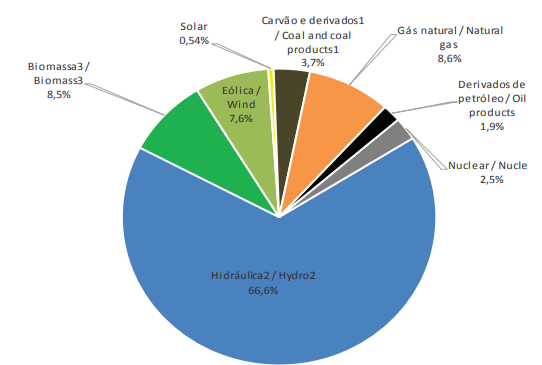

Matriz energética brasileira em 2019 segundo o Balanço Energético Nacional (BEN) por meio da Empresa de Pesquisa Energética (EPE).

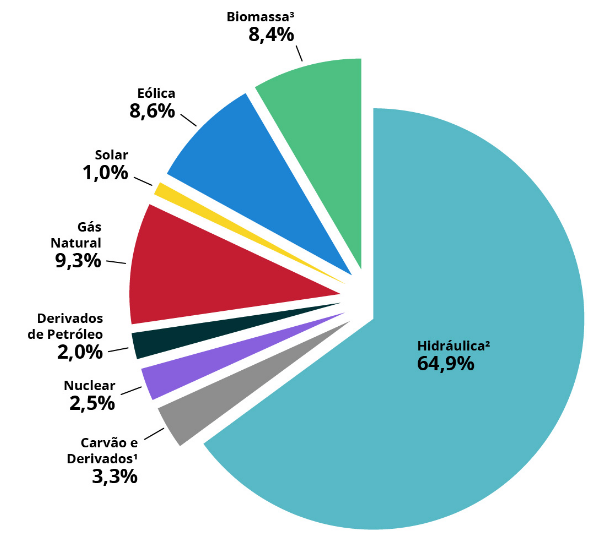

Matriz energética brasileira em 2020 segundo o Balanço Energético Nacional (BEN) por meio da Empresa de Pesquisa Energética (EPE).

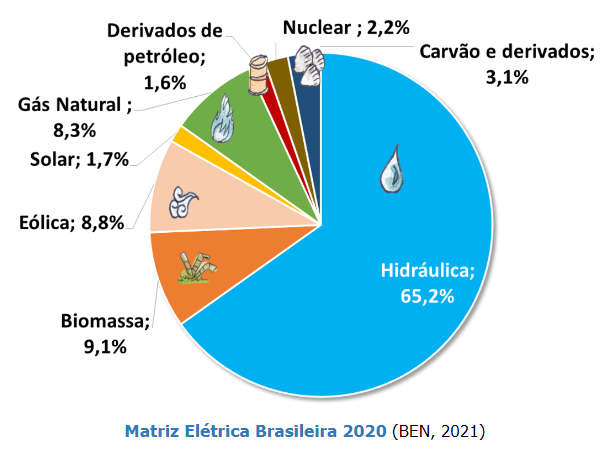

Fonte dos dados: [link text](https://www.aneel.gov.br/dados/geracao)

In [1]:

!pip install -q plotly
!pip install -q -U statsmodels
!pip install -q pmdarima

     |████████████████████████████████| 9.8 MB 15.3 MB/s 
     |████████████████████████████████| 1.4 MB 13.6 MB/s 


In [2]:
#Importações para manipulações de dados 
import numpy as np
import pandas as pd
import itertools
from pandas import Series

# Importações para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Importações para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 


# Importações para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

import pmdarima as pm

# Importações para formatação de gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 12,7
m.style.use('ggplot')
%matplotlib inline




In [3]:
#Importando os dados
arquivo = pd.read_excel('/content/drive/MyDrive/chuvas/odectve.xlsx')


In [4]:
arquivo.head()

,Oleo_Diesel_Combustivel,Data,Carvao gwh
0,20620,2013-01-22,10650
1,14020,2013-02-22,7010
2,12960,2013-03-25,9880
3,11590,2013-04-25,9480
4,14230,2013-05-26,11110


In [5]:
#  Transformando a data para datetime
arquivo['Data'] = pd.to_datetime(arquivo['Data'])

In [6]:
#Colocando Time como índice
arquivo = arquivo.set_index('Data')

In [7]:
#Fazendo a média mensal
O_C = arquivo['Oleo_Diesel_Combustivel'].resample('MS').mean() 

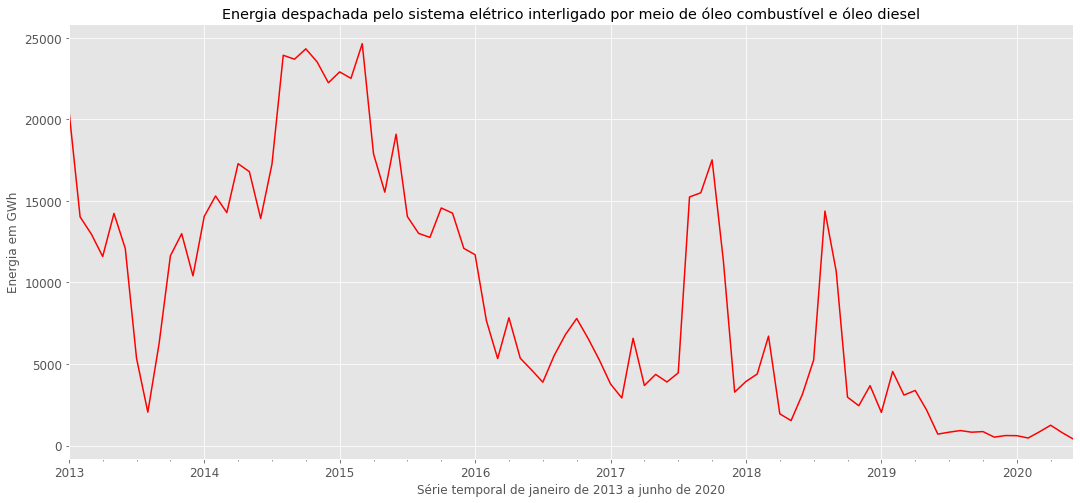

In [79]:
O_C.plot(figsize = (18, 8), color = 'red')
plt.xlabel("Série temporal de janeiro de 2013 a junho de 2020")
plt.ylabel('Energia em GWh')
plt.title("Energia despachada pelo sistema elétrico interligado por meio de óleo combustível e óleo diesel")
plt.show()

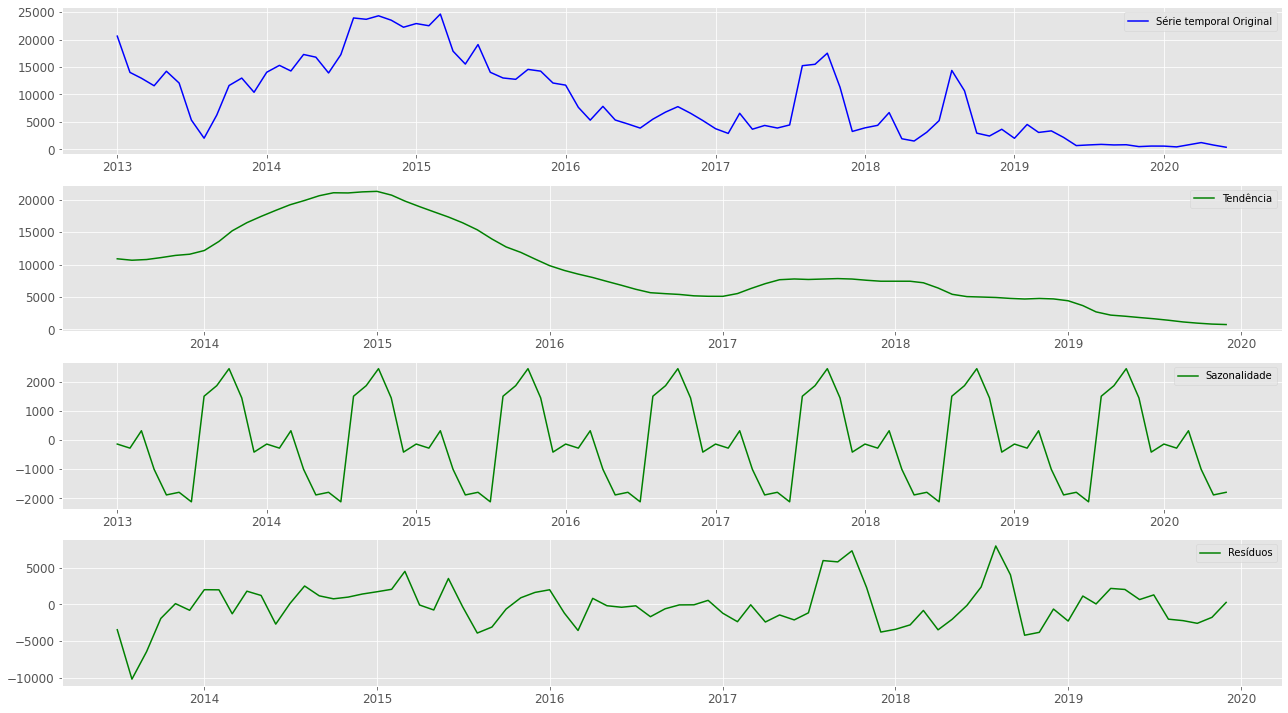

In [26]:
# Decomposição da série temporal de óleo diesel e óleo combustível
decomposition = seasonal_decompose(O_C, period = 12)
rcParams['figure.figsize'] = 18, 10

# Componentes 
tendencia = decomposition.trend
sazonalidade = decomposition.seasonal
residuos = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(O_C, label = 'Série temporal Original', color='blue')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(tendencia, label = 'Tendência', color='green')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(sazonalidade, label = 'Sazonalidade', color='green')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residuos, label = 'Resíduos', color='green')
plt.legend(loc = 'best')
plt.tight_layout()

In [28]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adfuller(arquivo['Oleo_Diesel_Combustivel'])



(-1.2074380363581199,
 0.6703878998430266,
 11,
 78,
 {'1%': -3.517113604831504,
  '10%': -2.5869547797501644,
  '5%': -2.8993754262546574},
 1442.367643814007)

#O valor-p é maior que 0.05 (valor-p =0.6703878998430266),  logo, não podemos  rejeitar a hipótese nula. Conclui-se que esta série provavelmente não é estacionária.

In [29]:
# Divisão dos dados em treino e em teste (75% treino e 25% teste)
X = O_C
treino = int(len(X) * 0.75)
train, test = X[0:treino], X[treino:]

In [30]:
# Definindo p, d e q para que tenham valores entre 0 e 2.
p = d = q = range(0, 2)

In [31]:
# combinações de p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [37]:
# Lista de combinações dos hiperparâmetros sazonais P, D e Q e hiperparâmetro S=12 porque deseja=se analisar sazonalidade anul. 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [38]:
# Grid Search


# Grid search para o menor valor possível para a estatística AIC 
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            resultados = mod.fit()
            
            # Print
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, resultados.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  resultados.aic:
                lowest = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, resultados.aic)
                lowest_aic = resultados.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1439.9882808092755
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1151.5058139264308
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1134.7329739445936
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:864.8069296634634
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1149.3337996490473
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1130.6277556568264
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:894.034312800986
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:861.5780355896228
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1371.8170913668623
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1114.1883883284404
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1080.5573704622063
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:828.8942755460029
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1104.1398303481576
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1115.0602117116741
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:871.4556601064445
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:830.4082498662983
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1234.170076087398
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1

#Embora que os valores encontrados foram SARIMA(0, 1, 1)x(1, 1, 1, 12)12, decidiu-se optar pelos hiperparâmetros abaixo.

In [39]:
# Treina o modelo com a melhor combinação de hiperparâmetros encontrada
modelo_sarima = sm.tsa.statespace.SARIMAX(train,
                                             order = (0, 1, 2),
                                             seasonal_order = (1, 0, 2, 12),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

In [40]:
# Treinamento (Fit) do modelo
modelo_sarima_fit = modelo_sarima.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



In [41]:
# Sumário do modelo
print(modelo_sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:            Oleo_Diesel_Combustivel   No. Observations:                   67
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -364.357
Date:                            Thu, 20 Jan 2022   AIC                            740.714
Time:                                    00:17:47   BIC                            750.695
Sample:                                01-01-2013   HQIC                           744.295
                                     - 07-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0111      0.189      0.059      0.953      -0.360       0.382
ma.L2         -0.0585      0.261   

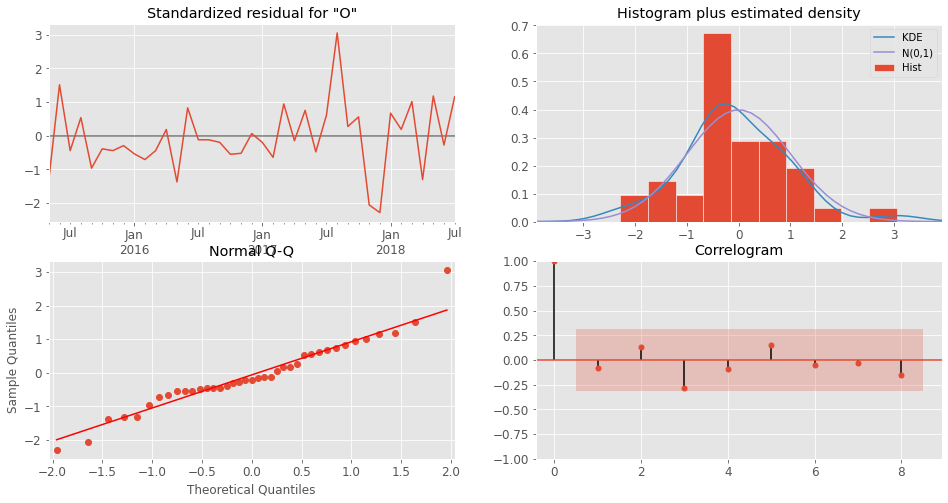

In [42]:
# Diagnóstico do modelo
modelo_sarima_fit.plot_diagnostics(lags = 8, figsize = (16,8))
plt.show()

In [46]:
# Previsões um passo a frente
sarima_predictions = modelo_sarima_fit.get_prediction(start = pd.to_datetime('2018-08-01'), 
                                                       end = pd.to_datetime('2020-06-01'),
                                                       dynamic = False)

In [47]:
# Intervalo de confiança
i_conf = sarima_predictions.conf_int()
i_conf

,lower Oleo_Diesel_Combustivel,upper Oleo_Diesel_Combustivel
2018-08-01,-121.954334,10676.303835
2018-09-01,-3334.657847,12020.093463
2018-10-01,-5457.393088,13028.759450
2018-11-01,-7277.932057,13881.177389
2018-12-01,-8419.782835,15110.548347
2019-01-01,-10980.024040,14704.456319
2019-02-01,-13546.391947,14144.680976
2019-03-01,-13338.461245,16223.425633
2019-04-01,-14607.619236,16688.048001
2019-05-01,-16713.547347,16224.745992


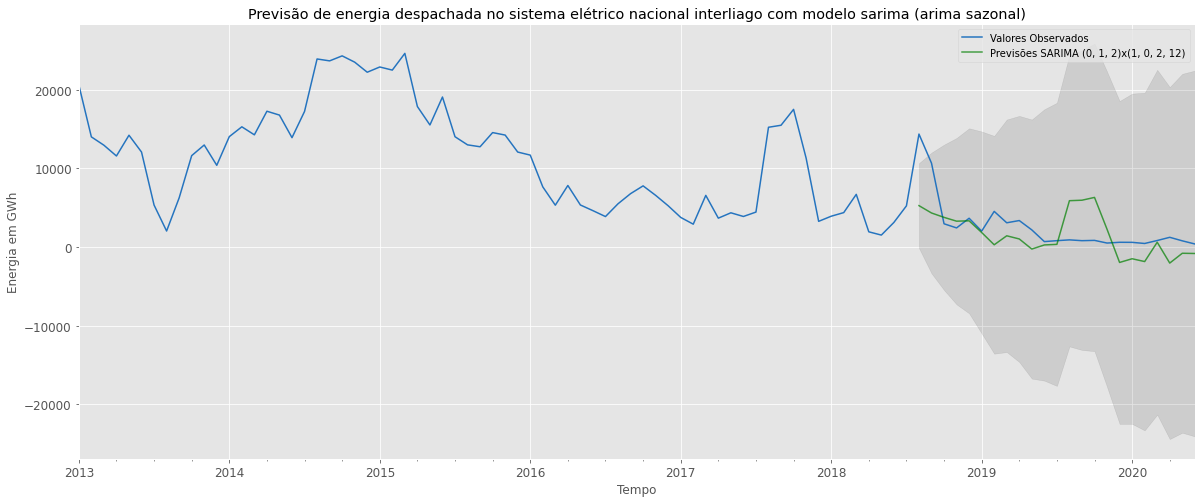

In [53]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados da série óleo combustível
ax = O_C.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predictions.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (0, 1, 2)x(1, 0, 2, 12)', 
                                     alpha = 0.7, 
                                     color = 'green') 

# Plot do intervalo de confiança
ax.fill_between(i_conf.index,
                # lower (menores valores previstos)
                i_conf.iloc[:, 0],
                # upper (maiores valores previstos)
                i_conf.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de energia despachada no sistema elétrico nacional interliago com modelo sarima (arima sazonal)')
plt.xlabel('Tempo')
plt.ylabel('Energia em GWh')
plt.legend()
plt.show()

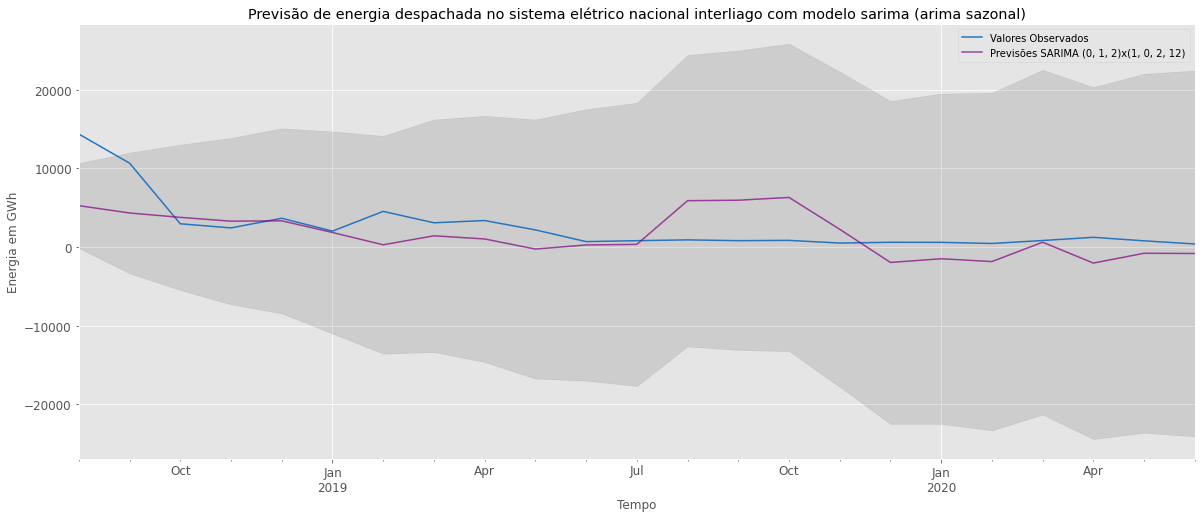

In [52]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados da série óleo combustível
ax = O_C.iloc[67:90].plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predictions.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (0, 1, 2)x(1, 0, 2, 12)', 
                                     alpha = 0.7, 
                                     color = 'purple') 

# Plot do intervalo de confiança
ax.fill_between(i_conf.index,
                # lower (menores valores previstos)
                i_conf.iloc[:, 0],
                # upper (maiores valores previstos)
                i_conf.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de energia despachada no sistema elétrico nacional interliago com modelo sarima (arima sazonal)')
plt.xlabel('Tempo')
plt.ylabel('Energia em GWh')
plt.legend()
plt.show()

#Cálculo de métricas para o modelo SARIMA


In [58]:
from sklearn.metrics import mean_squared_error
from math import sqrt

RMSE = sqrt(mean_squared_error(test, sarima_predictions.predicted_mean))
print('RMSE = ', RMSE)

RMSE =  3440.445276436534


In [62]:
MSE = RMSE**(2)
print('MSE = ', MSE)

MSE =  11836663.700154461


In [76]:
def MAPE(Y_teste,Y_Predito):
    mape = np.mean(np.abs((Y_teste - Y_Predito)/Y_teste))*100
    return(print('MAPE =', mape))


In [77]:
MAPE = MAPE(test, sarima_predictions.predicted_mean)

MAPE = 209.72183748792693
